# **Finance Pairs Formation**

# **Import libraries and dataset**

In [1]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
import statistics as stats
import plotly.graph_objects as go
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
import itertools
from heapq import nsmallest, nlargest
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,14)})

In [2]:
import sys
# locate the folder which stores the custom package using relative path
sys.path.append('../../../../../src')

import config_snippets as config_snp
import splitting_data as splitting_data
import gatev_distance_method as gatev_dist
import data_transformation_snippets as data_transform_snp
import time_series_analysis_snippets as tsa_snp
import engle_granger_cointegration_method as eg_coint
import johansen_cointegration_method as jj_coint 
import handling_dataframe as hdf
import handling_datetime as hdt


In [3]:
# Path to your config YAML file
config_file_path = "..//..//../config.yaml"

# Load the configuration
config = config_snp.load_config(config_file_path)

if config is not None:
    import ast
    # Access and use the parameters
    split_ratio = config.get("split_ratio")
    
    # Access and convert string to tuple
    train_period = ast.literal_eval(config.get("train_period"))
    test_period = ast.literal_eval(config.get("test_period"))
    
    # Get list of df_consumer_good data paths
    lst_df_consumer_good_paths = ast.literal_eval(config.get("paths_df_consumer_good_processed"))
    

In [4]:
# Import data 
path = lst_df_consumer_good_paths[0]
df = pd.read_csv(path)

In [5]:
# Set date as index
df.set_index("date", inplace=True)

In [6]:
df = df.dropna()

# **Split data**

In [7]:
# Example: split ratio = 0.7
df_train, df_test = splitting_data.splitting_data_by_ratio(
    df,
    split_ratio=split_ratio
)

In [8]:
# Example of splitting by specified period

# test_train, test_test = splitting_data_by_date(
#     df,
#     train_period = train_period,
#     test_period = test_period
# )

# **Gatev Distance Approach**

In [9]:
df_train

,adClose_DBC,adClose_DLG,adClose_HHS,adClose_HNG,adClose_IDI,adClose_SBT,adClose_TNG,adClose_TSC,adClose_TTF,adClose_VNM
date,,,,,,,,,,
2018-12-10,8.335,1.86,3.047,17.05,7.743,14.978,9.755,1.267,3.95,90.940
2018-12-11,8.367,1.85,3.025,16.90,7.705,14.941,9.704,1.267,3.72,90.805
2018-12-12,8.335,1.82,3.075,16.85,7.780,15.015,9.704,1.258,3.74,90.266
2018-12-13,8.429,1.79,3.039,16.70,7.818,15.610,9.908,1.258,3.71,90.940
2018-12-14,8.335,1.79,3.025,16.75,7.780,15.313,9.806,1.258,3.70,90.940
...,...,...,...,...,...,...,...,...,...,...
2019-09-18,7.727,1.58,2.216,16.95,5.082,14.728,10.949,2.112,2.88,86.420
2019-09-19,7.727,1.57,2.296,16.50,5.435,14.688,10.949,1.969,2.86,86.350
2019-09-20,7.795,1.56,2.296,16.30,5.660,14.770,10.889,1.942,2.91,85.302


## **Gatev Data Normalization**

In [10]:
df_cum_daily_returns_train = gatev_dist.gatev_data_normalize(df_train)

In [11]:
df_cum_daily_returns_train

,adClose_DBC,adClose_DLG,adClose_HHS,adClose_HNG,adClose_IDI,adClose_SBT,adClose_TNG,adClose_TSC,adClose_TTF,adClose_VNM
date,,,,,,,,,,
2018-12-11,3.839232e-01,-0.537634,-0.722022,-0.879765,-0.490766,-0.247029,-0.522809,0.000000,-5.822785,-0.148450
2018-12-12,-1.110223e-14,-2.150538,0.918937,-1.173021,0.477851,0.247029,-0.522809,-0.710339,-5.316456,-0.741148
2018-12-13,1.127774e+00,-3.763441,-0.262553,-2.052786,0.968617,4.219522,1.568426,-0.710339,-6.075949,0.000000
2018-12-14,-3.330669e-14,-3.763441,-0.722022,-1.759531,0.477851,2.236614,0.522809,-0.710339,-6.329114,0.000000
2018-12-15,-3.330669e-14,-3.763441,-0.722022,-1.759531,0.477851,2.236614,0.522809,-0.710339,-6.329114,0.000000
...,...,...,...,...,...,...,...,...,...,...
2019-09-18,-7.294541e+00,-15.053763,-27.272727,-0.586510,-34.366525,-1.669115,12.239877,66.692976,-27.088608,-4.970310
2019-09-19,-7.294541e+00,-15.591398,-24.647194,-3.225806,-29.807568,-1.936173,12.239877,55.406472,-27.594937,-5.047284
2019-09-20,-6.478704e+00,-16.129032,-24.647194,-4.398827,-26.901718,-1.388703,11.624808,53.275454,-26.329114,-6.199692


## **Gatev Distance Approach Pairs Formation**

In [12]:
gatev_dist.gatev_distance_matrix(df_cum_daily_returns_train)

In [13]:
gatev_pairs, list_result_smallest_dist = gatev_dist.gatev_distance_smallest(
    df=df_cum_daily_returns_train,
    top_values=10
)

In [14]:
for res in list_result_smallest_dist:
    print(res)
    
print(gatev_pairs)

Khoảng cách Euclide của adClose_DBC và adClose_HHS: 202.3
Khoảng cách Euclide của adClose_DBC và adClose_HNG: 139.6
Khoảng cách Euclide của adClose_DBC và adClose_SBT: 138.7
Khoảng cách Euclide của adClose_DBC và adClose_VNM: 135.4
Khoảng cách Euclide của adClose_DLG và adClose_TTF: 111.5
Khoảng cách Euclide của adClose_HHS và adClose_SBT: 201.5
Khoảng cách Euclide của adClose_HHS và adClose_TTF: 183.2
Khoảng cách Euclide của adClose_HNG và adClose_VNM: 188.1
Khoảng cách Euclide của adClose_IDI và adClose_TTF: 200.6
Khoảng cách Euclide của adClose_SBT và adClose_VNM: 78.6
[['adClose_DBC', 'adClose_HHS'], ['adClose_DBC', 'adClose_HNG'], ['adClose_DBC', 'adClose_SBT'], ['adClose_DBC', 'adClose_VNM'], ['adClose_DLG', 'adClose_TTF'], ['adClose_HHS', 'adClose_SBT'], ['adClose_HHS', 'adClose_TTF'], ['adClose_HNG', 'adClose_VNM'], ['adClose_IDI', 'adClose_TTF'], ['adClose_SBT', 'adClose_VNM']]


In [15]:
gatev_pairs

[['adClose_DBC', 'adClose_HHS'],
 ['adClose_DBC', 'adClose_HNG'],
 ['adClose_DBC', 'adClose_SBT'],
 ['adClose_DBC', 'adClose_VNM'],
 ['adClose_DLG', 'adClose_TTF'],
 ['adClose_HHS', 'adClose_SBT'],
 ['adClose_HHS', 'adClose_TTF'],
 ['adClose_HNG', 'adClose_VNM'],
 ['adClose_IDI', 'adClose_TTF'],
 ['adClose_SBT', 'adClose_VNM']]

# **Cointegration Approach**

## **Data Transformation**

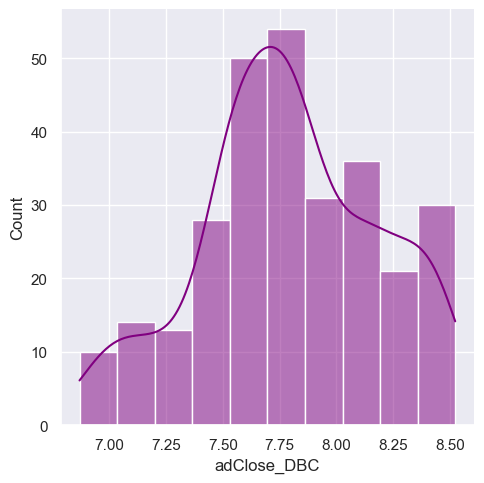

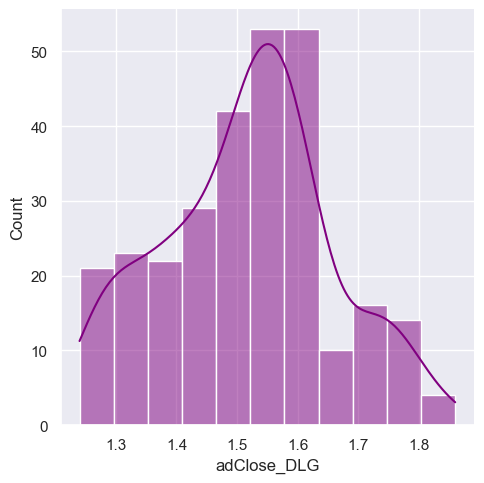

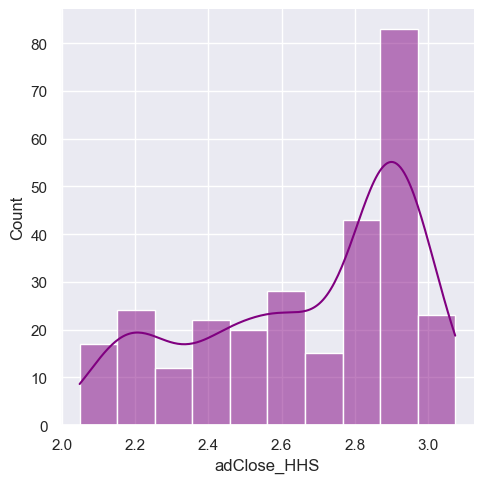

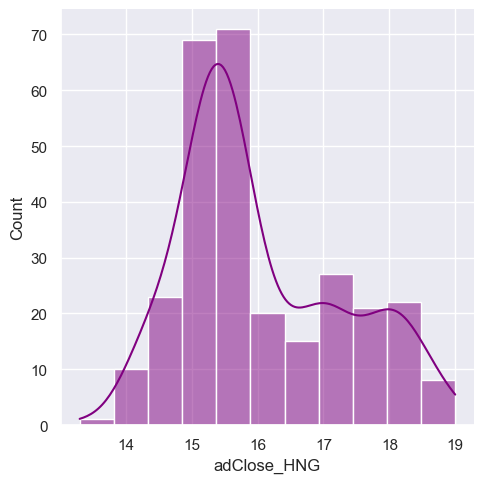

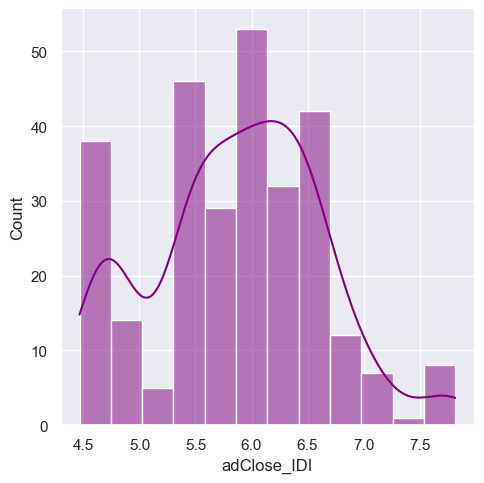

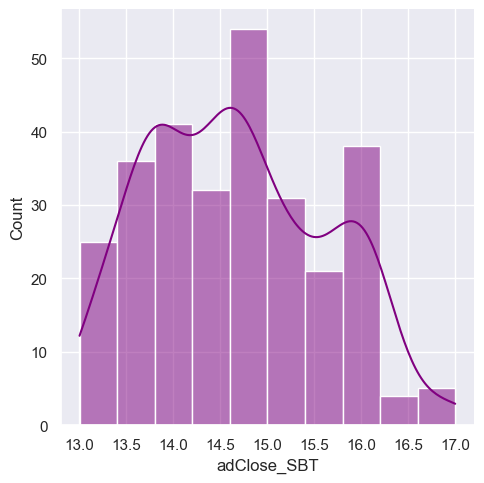

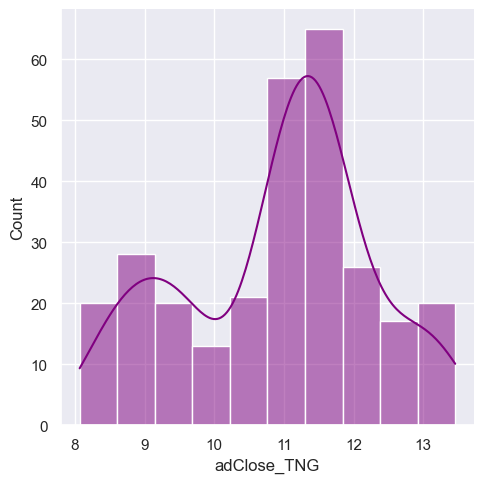

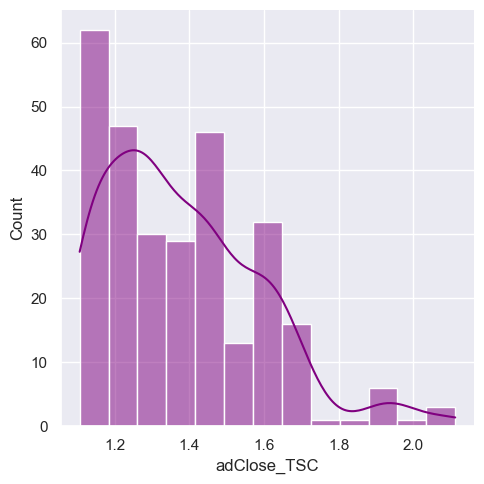

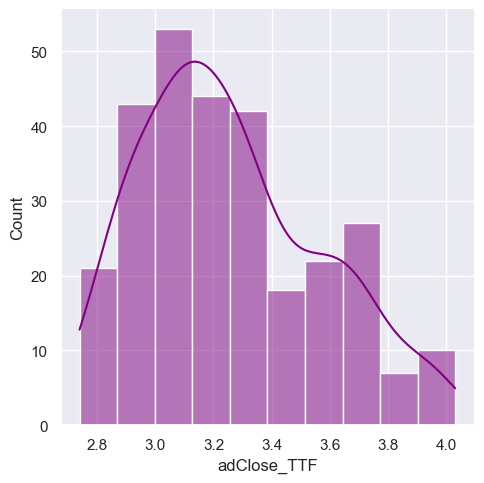

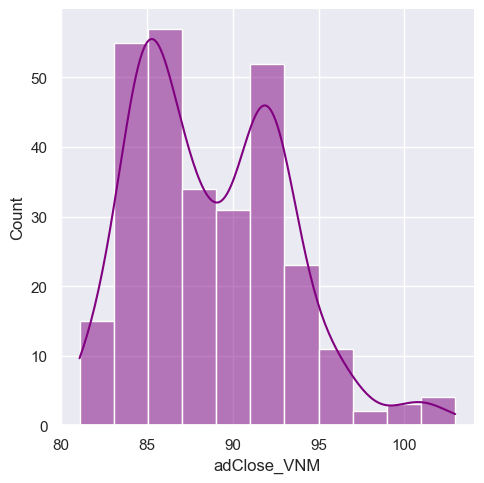

In [16]:
# Visualize distribution of values of each stock
data_transform_snp.dist_stock_visualization(df_train)

In [17]:
# Take natural log transformation of the data  
df_train_transformed = data_transform_snp.df_natural_log_transformed(df_train)

In [18]:
# Visualize distribution of transformed values of each stock
data_transform_snp.dist_stock_visualization(df_train_transformed)

## **Pretesting Stationary**

In [19]:
tsa_snp.find_integration_order(df_train_transformed)

,Column Name,Integration Order
0,adClose_DBC,0
1,adClose_DLG,1
2,adClose_HHS,1
3,adClose_HNG,1
4,adClose_IDI,0
5,adClose_SBT,1
6,adClose_TNG,1
7,adClose_TSC,1
8,adClose_TTF,1
9,adClose_VNM,1


## **Engle - Grange Method**

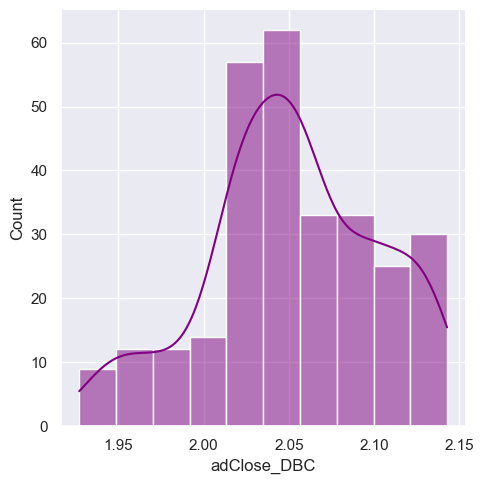

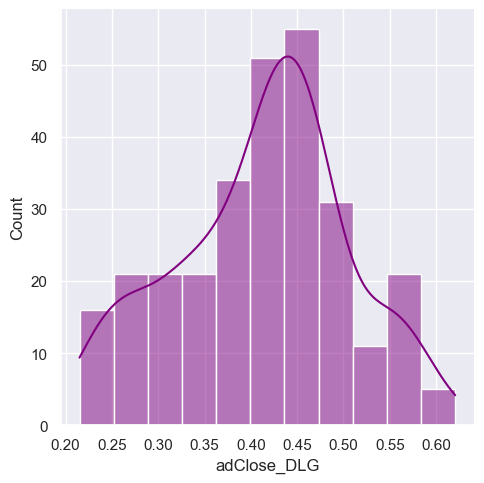

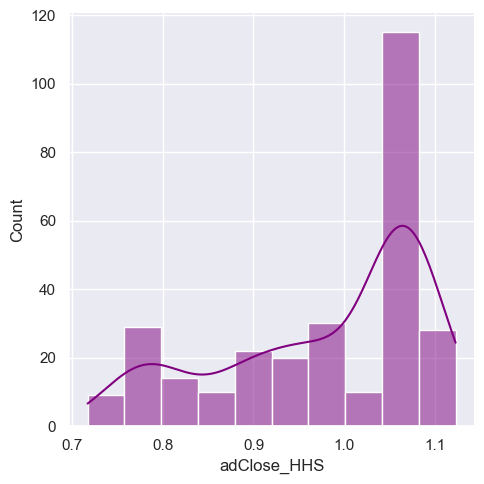

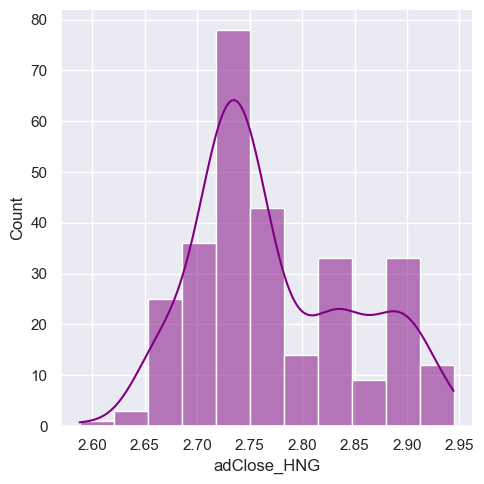

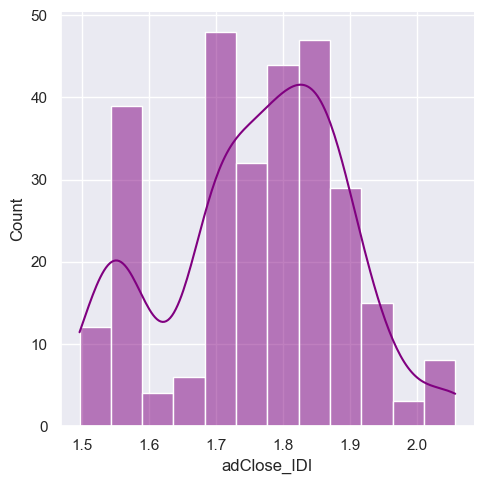

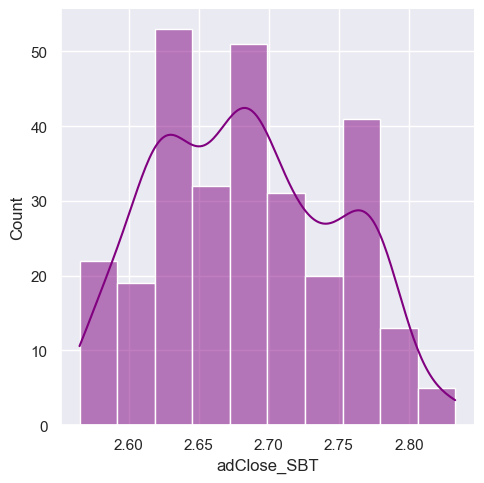

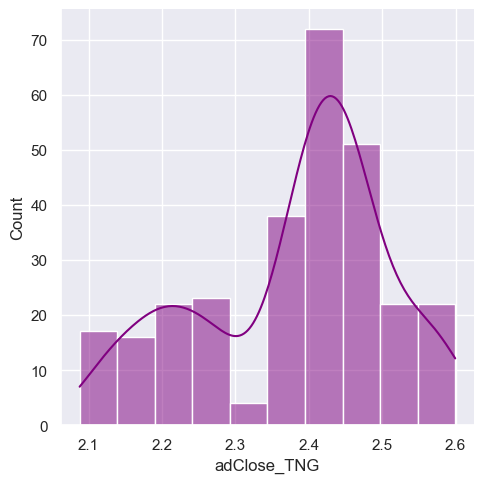

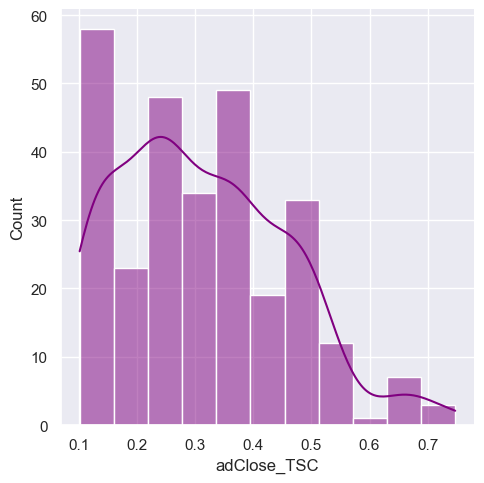

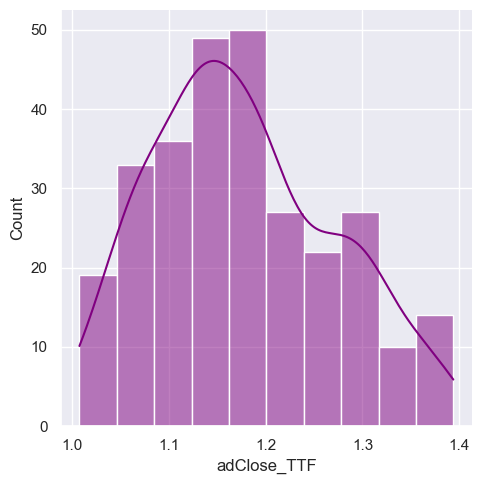

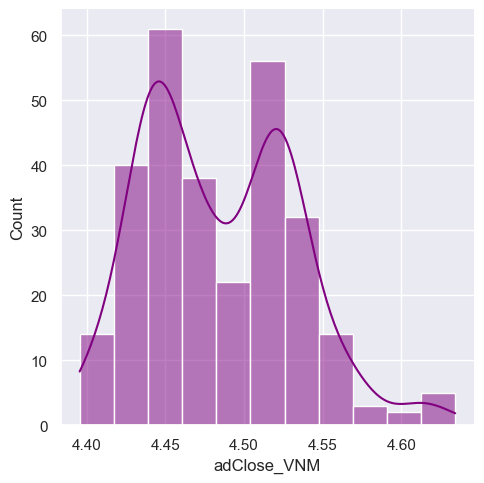

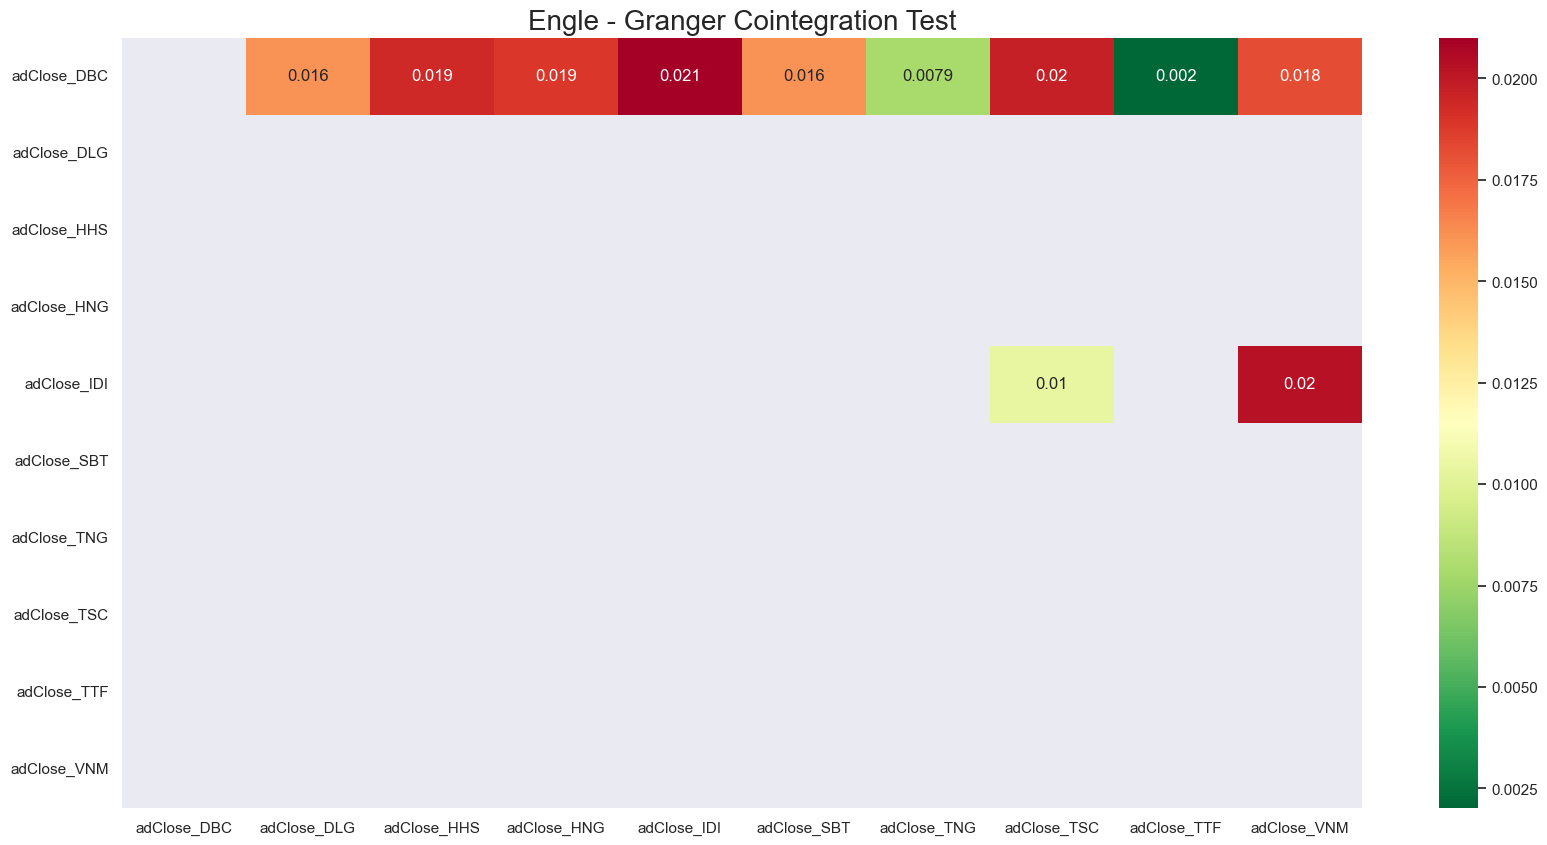

In [20]:
score_matrix, pvalue_matrix, eg_pairs = eg_coint.find_cointegrated_pairs(df_train_transformed)

In [21]:
eg_pairs 

[['adClose_DBC', 'adClose_DLG'],
 ['adClose_DBC', 'adClose_HHS'],
 ['adClose_DBC', 'adClose_HNG'],
 ['adClose_DBC', 'adClose_IDI'],
 ['adClose_DBC', 'adClose_SBT'],
 ['adClose_DBC', 'adClose_TNG'],
 ['adClose_DBC', 'adClose_TSC'],
 ['adClose_DBC', 'adClose_TTF'],
 ['adClose_DBC', 'adClose_VNM'],
 ['adClose_IDI', 'adClose_TSC'],
 ['adClose_IDI', 'adClose_VNM']]

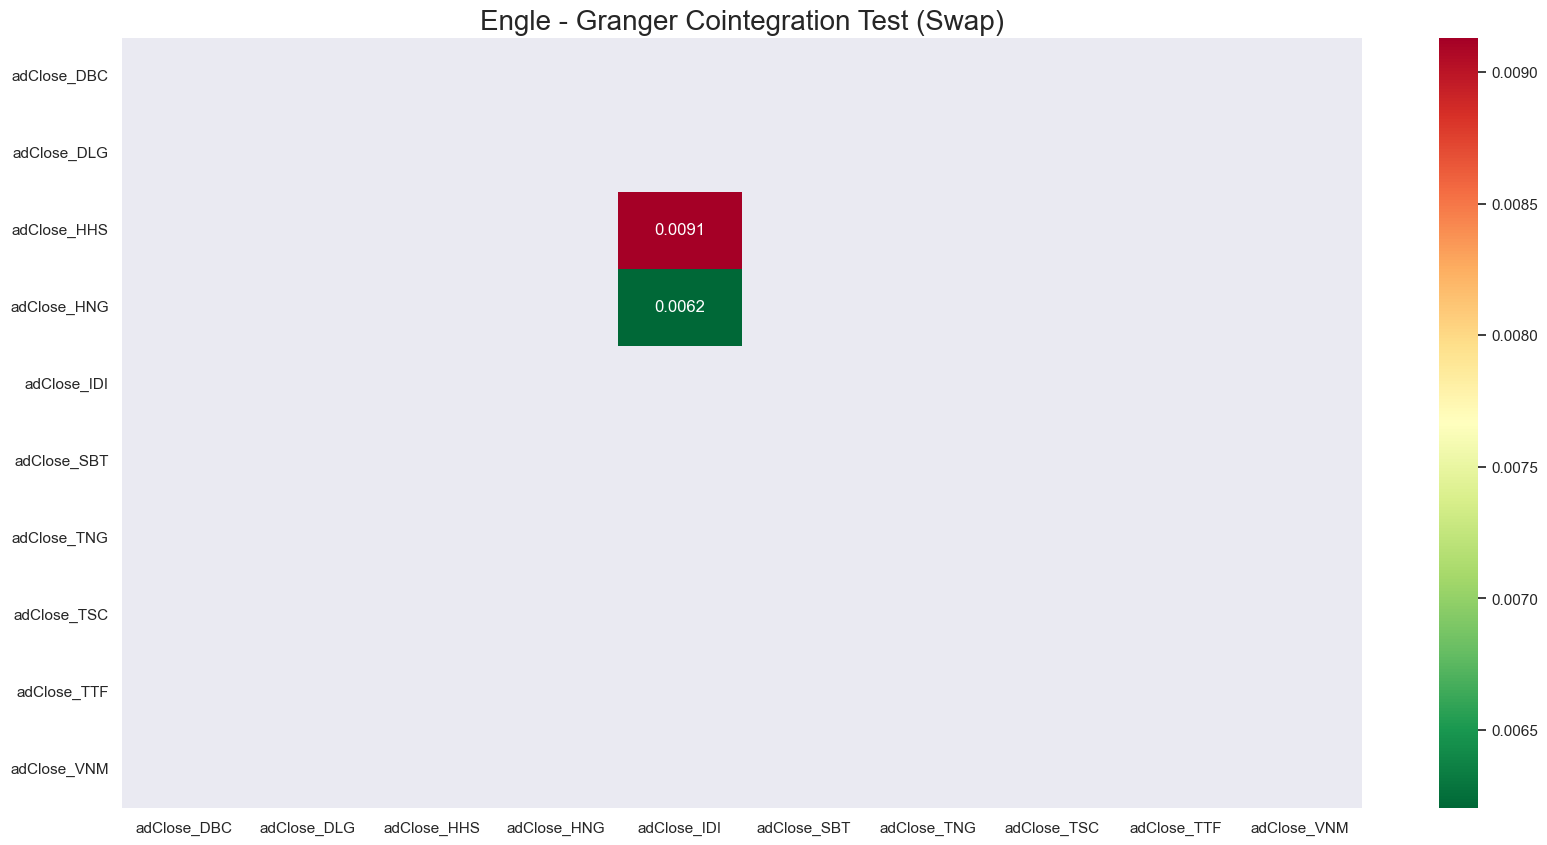

In [22]:
scores_swap, pvalues_swap, eg_pairs_swap = eg_coint.find_cointegrated_pairs_swap(df_train_transformed)

In [23]:
eg_pairs_swap

[['adClose_HHS', 'adClose_IDI'], ['adClose_HNG', 'adClose_IDI']]

## **Johansen Method**

In [24]:
johansen_pairs = jj_coint.johansen_test(df_train_transformed)

In [25]:
johansen_pairs

[['adClose_DBC', 'adClose_DLG'],
 ['adClose_DBC', 'adClose_HNG'],
 ['adClose_DBC', 'adClose_IDI'],
 ['adClose_DBC', 'adClose_SBT'],
 ['adClose_DBC', 'adClose_TNG'],
 ['adClose_DBC', 'adClose_TTF'],
 ['adClose_DBC', 'adClose_VNM'],
 ['adClose_DLG', 'adClose_IDI'],
 ['adClose_DLG', 'adClose_TNG'],
 ['adClose_DLG', 'adClose_VNM'],
 ['adClose_HNG', 'adClose_IDI'],
 ['adClose_IDI', 'adClose_SBT'],
 ['adClose_IDI', 'adClose_VNM']]

# **Result Summary**

In [26]:
df_pairs_formation_train = hdf.pairs_formation_result_summary(
    gatev_pairs,
    eg_pairs,
    eg_pairs_swap,
    johansen_pairs
)

In [27]:
df_pairs_formation_train

,Stock A,Stock B,Gatev Pairs,EG Pairs,EG Pairs Swap,Johansen Pairs,Count
0,adClose_DBC,adClose_DLG,,x,,x,2
1,adClose_DBC,adClose_HHS,x,x,,,2
2,adClose_DBC,adClose_HNG,x,x,,x,3
3,adClose_DBC,adClose_IDI,,x,,x,2
4,adClose_DBC,adClose_SBT,x,x,,x,3
5,adClose_DBC,adClose_TNG,,x,,x,2
6,adClose_DBC,adClose_TSC,,x,,,1
7,adClose_DBC,adClose_TTF,,x,,x,2
8,adClose_DBC,adClose_VNM,x,x,,x,3
9,adClose_DLG,adClose_IDI,,,,x,1


In [29]:
df_pairs_formation_train.to_csv(
    f"..//..//..//..//..//results//pairs_formation//consumer_good//consumer_good_pairs_formation_first_period_{hdt.today_date_to_digits()}.csv"
    )